# Classification. Linear models and KNN

In [1]:
import math
import os
#from unittest.mock import inplace

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init

    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        sigmoid = []
        for line in X:
            sigmoid.append(1/(1 + math.exp(-line @ weights)))
        return sigmoid
        # pass
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        loss = 0
        i = 0
        for line in x:
            M = y[i]*(weights @ line)
            loss += math.log(1 + math.exp(-M))
            i = i + 1
        loss = loss / len(y) + (np.linalg.norm(weights) ** 2) / (2 * self.C)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        num_objects = X.shape[0]
        self.loss_ = []
        for i in range(self.max_iter):
            self.loss_.append(self.get_loss(X_ext, self.weights_, y))
            old_weights = self.weights_.copy()
            it = (y[i] * X_ext[i] * (1 - 1/(1 + math.exp(-y[i] * (self.weights_ @ X_ext[i])))) for i in range(num_objects))
            delta = (-1/num_objects) * sum(it) + (1/self.C) * self.weights_
            self.weights_ -= self.eta * delta
            if np.linalg.norm(old_weights - self.weights_) < self.tol:
                break
        self.iters_= i

    def visualize_loss(self):
        if hasattr(self, 'loss_'):
            plt.plot(range(len(self.loss_)), self.loss_)
            plt.xlabel('number of iteration')
            plt.ylabel('values of the loss function')
            plt.grid(True)
        else:
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        probabilities = self.predict_proba(X)
        return np.sign(np.array(probabilities) - 0.5)



In [5]:
from sklearn import datasets
from sklearn import metrics

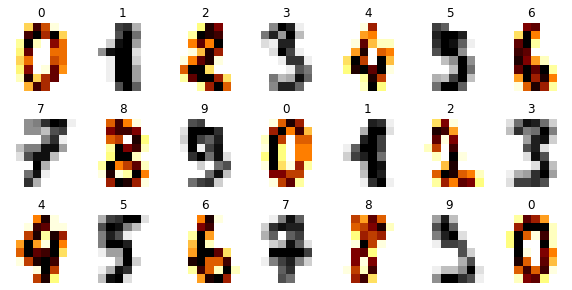

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()
print('success')

success


In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))
print('success')

success


In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)
print('success')

success


In [13]:
model = CustomLogisticRegression()

C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


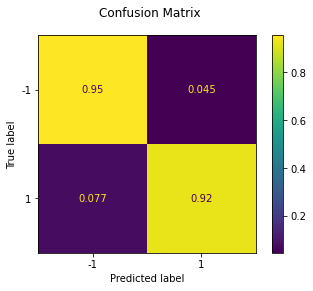

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9
print('success')

success


**(0.5 points)** Visualize the loss history.

As we can see the loss is decreasing

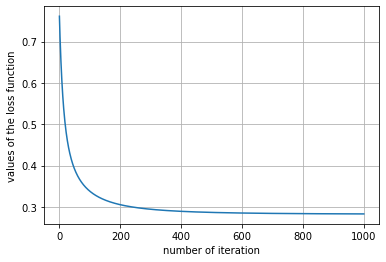

In [17]:
## your code
model.visualize_loss()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [18]:
## your code
Eta = np.arange(0.0001, 0.01, 0.0001)
num_iter = [] # list of numbers of iterations for gradient method depending on the value eta
for eta in Eta:
    model = CustomLogisticRegression()
    model.eta = eta
    model.fit(X_train, y_train)
    num_iter.append(model.iters_)

#num_iter

The range of values of eta for which gradient descent is convergence (from to): 0.0028 0.006900000000000001
The best eta: 0.006900000000000001


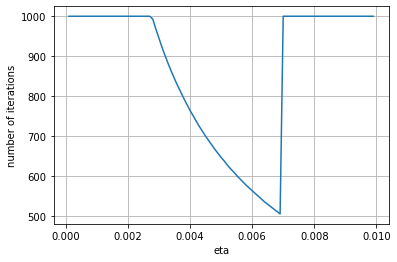

In [19]:
plt.plot(Eta, num_iter)
plt.xlabel('eta')
plt.ylabel('number of iterations')
plt.grid(True)

num_iter = np.array(num_iter)
convergence_area = np.where(num_iter < 999)[0]
l = Eta[convergence_area[0]]
r = Eta[convergence_area[-1]]
print('The range of values of eta for which gradient descent is convergence (from to):', l, r)
print('The best eta:', Eta[np.argmin(num_iter)])

The gradient method performs minimum of the number of iterations when learning rate $\eta$ = 0.0069

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [ ]:
c_values = np.arange(0.1, 2, 0.1)
train_accs, test_accs = [], []
for C in c_values:
    model = CustomLogisticRegression()
    model.C = C
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

#print(train_accs, test_accs)

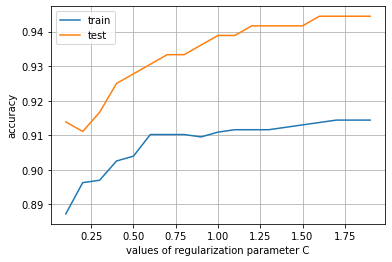

In [21]:
plt.plot(c_values, train_accs, label = 'train')
plt.plot(c_values, test_accs, label = 'test')
plt.xlabel('values of regularization parameter C')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

Increasing the parameter $C$ leads to increasing accuracy

**(0.5 points)** Compare zero initialization and random initialization. 

C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


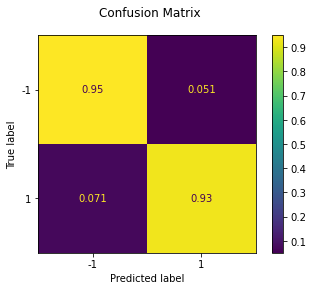

train accuracy in the model with zero initialization  0.9116214335421016
test accuracy in the model with zero initialization  0.9388888888888889


C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


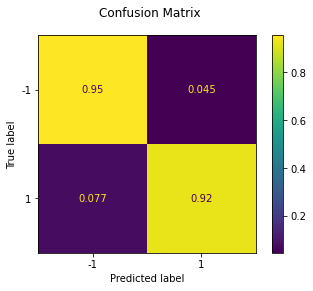

train accuracy in the model with random initialization  0.9109255393180237
test accuracy in the model with random initialization  0.9388888888888889


In [22]:
## your code
model = CustomLogisticRegression()
model.zero_init = True
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train accuracy in the model with zero initialization ', train_acc)
print('test accuracy in the model with zero initialization ', test_acc)

model = CustomLogisticRegression()
model.zero_init = False
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train accuracy in the model with random initialization ', train_acc)
print('test accuracy in the model with random initialization ', test_acc)


Test accuracy does not depend on the type of initialization. The model with zero initialization provides the accuracy 0.911 while the model with random initialization provides the accuracy 0.9109

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [23]:
from sklearn.metrics.pairwise import euclidean_distances

class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return metrics.pairwise.euclidean_distances(X, Y)
        # pass
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        #print(self.classes_)
        dict = {}
        count = 0
        for cl in self.classes_:
            dict[cl] = count
            count += 1
        df = pd.DataFrame({'y': y, 'weights': weights})
        df = df.groupby('y')['weights'].sum()
        ind = np.array(df.index)
        val = df.values
        index_positions = [dict[cl] for cl in ind]
        df = pd.DataFrame({'ind': index_positions, 'val': val})
        #print(df)
        p = np.zeros(len(self.classes_))
        for index, row in df.iterrows():
            p[int(row['ind'])] = row['val']
        #print(p.shape)
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            #print('y', self.y)
            #print('classes', self.classes_)
            #print('X', X)
            # print(P)
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1.0 / (np.array(P) + self.eps)
            #print(weights_of_points)
            n_samples = X.shape[0]
            y = np.zeros((n_samples, len(self.classes_)))
            for i in range(n_samples):
                for j in range(len(self.classes_)):
                    df = pd.DataFrame({'values': weights_of_points[i], 'dist': P[i]})
                    df.sort_values(by='dist', inplace=True)
                    df.drop(columns=['dist'])
                    #print(df)
                    nearest = df[0:self.n_neighbors]
                    # print(nearest)
                    ind = np.array(nearest.index)
                    y_ind = [self.y[i] for i in ind]
                    weights = np.array(nearest['values'])
                    #print('y_ind', y_ind)
                    #print('weights', weights)
                    class_weights = self.get_class_weights(y_ind, weights)
                    #print('class weights ', class_weights)
                    total_weight = np.sum(class_weights)
                    y[i, j] = class_weights[j]/total_weight
            return y
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>

        p = self.predict_proba(X)
        pos = [np.argmax(l) for l in p]
        return [self.classes_[i] for i in pos]
        # pass

In [24]:

model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [25]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))
'success'

'success'

In [26]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))
'success'

'success'

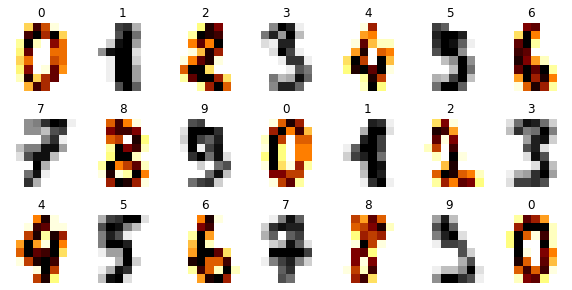

In [27]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [28]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [29]:
#print(model.predict_proba(X_test[0:1]))
#print(knn.predict_proba(X_test[0:1]))
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))
'success'

'success'

C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


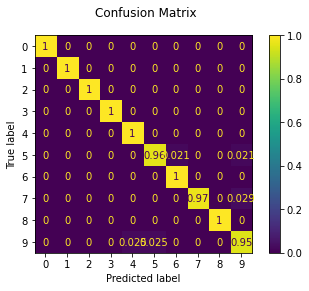

In [30]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [31]:
assert train_acc == 1
assert test_acc > 0.98
'success'

'success'

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

On the test data our model correct predicts the numbers 0, 1, 2, 3, 4, 6 and 8 for 100% cases; the number 5 only in 96% cases (5 was confused with 6 and 9); the number 9 only for 95 % (9 was confused with 4 and 5)

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [32]:
## your code
N = range(1, 10)
p = []
for n in N:
    model = CustomKNeighborsClassifier(n_neighbors=n, weights='distance')
    model.fit(X_train, y_train)
    y = model.predict_proba(X_test)
    p.append(y)
#p

In [33]:
[np.count_nonzero(li) for li in p]

[360, 364, 373, 379, 384, 392, 405, 412, 421]

Increasing the number of neighbours k leads to increasing non-zero class probabilities.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


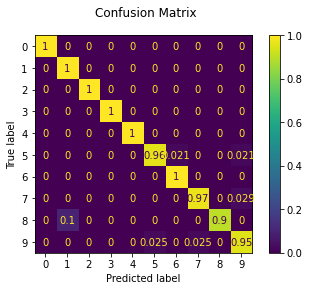

train_acc and test_acc for the weight type distance:  1.0 0.9777777777777777


C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


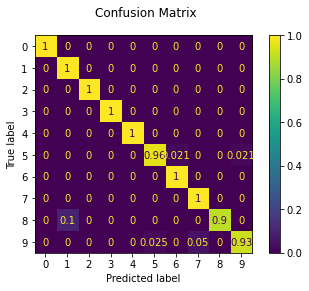

train_acc and test_acc for the weight type uniform:  0.97633959638135 0.9777777777777777


In [34]:
## your code
model = CustomKNeighborsClassifier(n_neighbors=20, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train_acc and test_acc for the weight type distance: ', train_acc, test_acc)


model = CustomKNeighborsClassifier(n_neighbors=20, weights='uniform')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train_acc and test_acc for the weight type uniform: ', train_acc, test_acc)


As we can see these two cases different each other in the accuracy of performing for train samples. The method works faster for `uniform` weights than for `distance` weights. We need to use weights based on `distance` when performing time is less important than the accuracy for train samples. Otherwise, we should use `uniform` weights.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

We can use distance measurements like the Manhattan distance $$dist(x, y) = \max_{i \in \{1, 2, \ldots, n\}}{|x_i - y_i|}$$ or $p$-distances ($3 \leq p < +\infty$) $$dist(x, y) = \left(\sum_{i=1}^{n}{|x_i - y_i|^p} \right)^{1/p}$$

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

We can study influence hyperparameter `tol` to the number of iterations of the gradient descent. It would be interested to investigate the best values of the hyperparameters `learning rate` $eta$, `regularization` $C$ related to the rate of convergence of the gradient descent

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [35]:
PATH = "../2_data_exploration"

In [36]:
data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')

In [37]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [38]:
females = len(data[data['Sex'] == 'female'])
males = len(data[data['Sex'] == 'male'])
print('Females', females)
print('Males', males)

print('Survived passengers', len(data[data['Survived'] == 1]))
print('Deceased', len(data[data['Survived'] == 0]))

survived_females = data[(data['Sex'] == 'female') & (data['Survived'] == 1)].shape[0] / females
survived_males = data[(data['Sex'] == 'male') & (data['Survived'] == 1)].shape[0] /males

print('Percent of the survived females', survived_females * 100)
print('Percent of the survived males', survived_males * 100)

Females 43886
Males 56114
Survived passengers 42774
Deceased 57226
Percent of the survived females 71.15253155903933
Percent of the survived males 20.579534519014864


C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


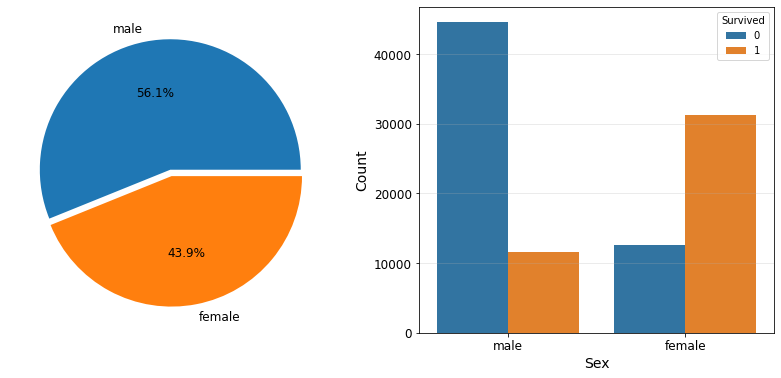

In [39]:
f,ax=plt.subplots(1,2,figsize=(14,6))
# plt.suptitle('Number of males and females', fontsize = 16, fontweight = 'bold')
data['Sex'].value_counts().plot.pie(explode=[0,0.05],autopct='%1.1f%%',textprops={'fontsize': 12},ax=ax[0])

ax[0].set_ylabel('')
sns.countplot('Sex',data = data,hue='Survived',ax=ax[1])
ax[1].tick_params(labelsize=12)
ax[1].set_xlabel('Sex', fontsize = 14)
ax[1].set_ylabel('Count', fontsize = 14)
ax[1].grid(axis = 'y', alpha = 0.3)
plt.show()

Survival rate depends on gender (the percent of survived females is significant higher than percent of survived males)

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Text(0, 0.5, 'number of person')

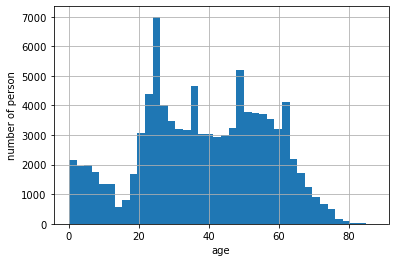

In [40]:
## your code
data.Age.hist(bins=40)
plt.xlabel("age")
plt.ylabel("number of person")

C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Persons')

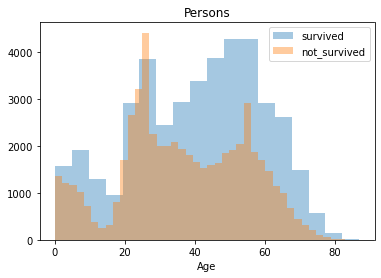

In [41]:
a = sns.distplot(data[data['Survived']==1].Age.dropna(), bins=18, label = 'survived', kde =False)
a = sns.distplot(data[data['Survived']==0].Age.dropna(), bins=40, label = 'not_survived', kde =False)
a.legend()
a.set_title('Persons')

In [42]:
data[data['Survived'] == 0]['Age'].describe()

count    55290.000000
mean        36.708695
std         17.809058
min          0.080000
25%         24.000000
50%         36.000000
75%         52.000000
max         83.000000
Name: Age, dtype: float64

In [43]:
data[data['Survived'] == 1]['Age'].describe()

count    41418.000000
mean        40.553799
std         18.742172
min          0.080000
25%         27.000000
50%         43.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

Survival rate is higher for older persons. Age distributions differ for survived and deceased passengers, as elderly people put on lifeboats first.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [44]:
# Calculation `Survival rate` over `Embarked`
data['Double'] = data['Survived']
pivot_table = data.pivot_table(values = ['Survived'], index = ['Embarked'], columns = ['Double'], aggfunc='count')

print(pivot_table)
p = pivot_table['Survived']
s1 = pd.Series([p[0][0], p[0][1], p[0][2]])
s2 = pd.Series([p[1][0], p[1][1], p[1][2]])
df = pd.DataFrame(columns = ['Survived', 'Not Survived', 'Total'])
df['Survived'] = s2
df['Not Survived'] = s1
df['Total'] = df['Survived'] + df['Not Survived']
df['Percentage'] = df['Survived']/df['Total']*100
df.index = ['C', 'Q', 'S']
print(df)

         Survived       
Double          0      1
Embarked                
C            5518  16669
Q            2186   3238
S           49394  22745
   Survived  Not Survived  Total  Percentage
C     16669          5518  22187   75.129580
Q      3238          2186   5424   59.697640
S     22745         49394  72139   31.529409


In [45]:
pivot_table = data.pivot_table(values = ['Survived'], index = ['Pclass'], columns = ['Double'], aggfunc='count')


p = pivot_table['Survived']
s1 = pd.Series([p[1][1], p[1][2], p[1][3]])
s2 = pd.Series([p[0][1], p[0][2], p[0][3]])
df = pd.DataFrame(columns = ['Survived', 'Not Survived', 'Total'])
df['Survived'] = s1
df['Not Survived'] = s2
df['Total'] = df['Survived'] + df['Not Survived']
df['Percentage'] = df['Survived']/df['Total']*100
df.index = df.index + 1
df

,Survived,Not Survived,Total,Percentage
1,17576,12739,30315,57.977899
2,15057,13622,28679,52.501831
3,10141,30865,41006,24.730527


C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\ProgramData\Anaconda3\envs\ml-intro\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


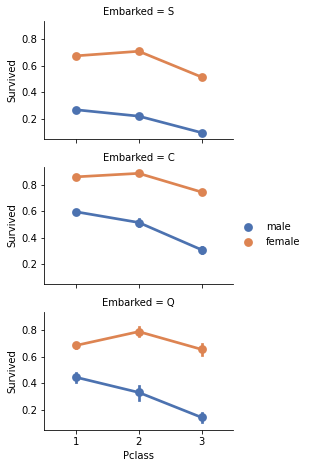

In [46]:
grid = sns.FacetGrid(data, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

The safest embarked is 'C' (75% chances to survive). The safest ticket classes are the first and second classes. Chances to survive for passengers with the 1st and 2nd class ticket are approximately equal. As we can cee chances to survive for a passenger with the 1st ticket class are different for different embarked. Port of embarkation correlates with survival rates.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [47]:
## your code
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
Survived,Survived,0.000
Pclass,Pclass,0.000
Name,Name,0.000
Sex,Sex,0.000
Age,Age,3.292
SibSp,SibSp,0.000
Parch,Parch,0.000
Ticket,Ticket,4.623
Fare,Fare,0.134
Cabin,Cabin,67.866


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

If the number of Nan values in a feature is sufficient small amount then we can remove objects with these Nan values. If Nan values in a feature is too much then we can remove this feature. As alternative, in continuous features Nan values we can replace by mean or median values. Nan values in nominal feature we can replace by the most frequency value.

We fill nan values in the feature 'Age' by mean. The feature 'Cabin' contains too much nan values. We remove this feature. The values nan of the feature 'Embarked' we fill by the most frequency embarked.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [48]:
## your code
train_data = data.copy()
test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')

In [49]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Double
PassengerId,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S,1
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S,0
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S,0
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S,0
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S,1


In [50]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [51]:
train_data['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

In [52]:
test_data['Embarked'].value_counts()

S    68842
C    22308
Q     8573
Name: Embarked, dtype: int64

In [53]:
# We replace nan values in the feature 'Age' with mean
train_data.fillna(train_data['Age'].mean(skipna=True), inplace=True)
test_data.fillna(train_data['Age'].mean(skipna=True), inplace=True)

train_data.drop(columns=['Cabin'], inplace=True)
test_data.drop(columns=['Cabin'], inplace=True)

train_data.fillna('S', inplace=True)
test_data.fillna('S', inplace=True)

train_data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
Double      0
dtype: int64

In [54]:
test_data.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [55]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

y_train = train_data['Survived']
x_train = train_data[['Age', 'Fare']]

results = cross_validate(LogisticRegression(), x_train, y_train, cv=5, scoring=['accuracy'])
print(results['test_accuracy'].mean())

results = cross_validate(KNeighborsClassifier(n_neighbors=5, weights='distance'), x_train, y_train, cv=5, scoring=['accuracy'])
print(results['test_accuracy'].mean())

0.61498
0.5885199999999999


As we can see KNN shows less `accuracy` than Logistic Regression

In [56]:
x_train

,Age,Fare
PassengerId,,
0,38.355472,27.14
1,38.355472,13.35
2,0.330000,71.29
3,19.000000,13.04
4,25.000000,7.76
...,...,...
99995,62.000000,14.86
99996,66.000000,11.15
99997,37.000000,9.95


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [57]:
## your code
train_data['Males'] = train_data['Sex'].apply(lambda x : 1 if x == 'male' else 0)
#train_data['Females'] = train_data['Sex'].apply(lambda x : 1 if x == 'female' else 0)

test_data['Males'] = test_data['Sex'].apply(lambda x : 1 if x == 'male' else 0)

train_data['Embarked_C'] = train_data['Embarked'].apply(lambda x : 1 if x == 'C' else 0)
train_data['Embarked_S'] = train_data['Embarked'].apply(lambda x : 1 if x == 'S' else 0)
#train_data['Embarked_Q'] = train_data['Embarked'].apply(lambda x : 1 if x == 'Q' else 0)

test_data['Embarked_C'] = test_data['Embarked'].apply(lambda x : 1 if x == 'C' else 0)
test_data['Embarked_S'] = test_data['Embarked'].apply(lambda x : 1 if x == 'S' else 0)


train_data['Pclass1'] = train_data['Pclass'].apply(lambda x : 1 if x == 1 else 0)
train_data['Pclass2'] = train_data['Pclass'].apply(lambda x : 1 if x == 2 else 0)
#train_data['Pclass3'] = train_data['Pclass'].apply(lambda x : 1 if x == 3 else 0)

test_data['Pclass1'] = test_data['Pclass'].apply(lambda x : 1 if x == 1 else 0)
test_data['Pclass2'] = test_data['Pclass'].apply(lambda x : 1 if x == 2 else 0)



features = ['Age', 'Fare', 'Males', 'Embarked_C', 'Embarked_S']

y_train = train_data['Survived']
x_train = train_data[features]

results = cross_validate(LogisticRegression(), x_train, y_train, cv=5, scoring=['accuracy'])
print(results['test_accuracy'].mean())

0.7622899999999999


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [58]:
x_test = test_data[features]

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
a = logreg.predict(x_test)
df = pd.DataFrame(a)
df.index = pd.DataFrame(a).index + 100000
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'PassengerId', 0:'Survived'})
df
df.to_csv('out.csv', index=False)

![](2022-04-02.png)